In [1]:
from torch.nn import Parameter
import torch.nn.functional as F
import torch

import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)
    import config

In [19]:
class ExperimentBase:
    def config(self):
        raise NotImplementedError

    def run(self):
        raise NotImplementedError
    
from FeatureSelection.Experiments import Model
class BrainCancerHSIBandSelectionBase(ExperimentBase):
    def __init__(self) -> None:
        super().__init__()
        self.model = Model([128, 150, 64, 3], fs_threshold=.9, fs_tau=.2) 

    def config(self):
        return {
            'dataset_dir': config.BRAIN_HSI_DIR,
            'dataset': 'BrainCancerHSI',
            'model': self.model,
            'train_size': 0.8,
            'test_size': 0.2,
            'batch_size': 32,
            # 'batch_size': 64,
            # 'batch_size': 128,
            'epochs': 300,
            'lr': 1e-3,
            'seed': 42,
            'log_interval': 10,
            'save_model': False,
            'save_model_dir': 'Test', #config.MODEL_DIR,
            'save_model_name': 'BrainCancerHSIBandSelection.pt',
            'save_result': True,
            'save_result_dir': os.path.join(config.RESULTS_DIR, 'Chapter6/BrainCancerHSI'),
            'save_result_name': 'BrainCancerHSIBandSelection.pkl'
        }

from FeatureSelection.Experiments import BrainCancerHSIDataset
from FeatureSelection.Experiments.utils import Normalize
import pandas as pd

class VNIRimagesOp8C1(BrainCancerHSIBandSelectionBase):
    def __init__(self) -> None:
        super().__init__()
        self.experiment = 'VNIRimagesOp8C1'
        self.data_dir = os.path.join(config.BRAIN_HSI_DIR, f'preprocessed/data/no_outliers/{self.experiment}/')

        mean_std_df = pd.read_csv(os.path.join(self.data_dir, 'mean_std.csv'))
        self.transform = Normalize(mean_std_df['mean'], mean_std_df['std'])
        self.dataset = BrainCancerHSIDataset(self.data_dir, transform=self.transform)
        
        generator = torch.Generator().manual_seed(42)

        train_size = int(0.9 * len(self.dataset))
        test_size = len(self.dataset) - train_size
        self.train_dataset, self.test_dataset = torch.utils.data.random_split(self.dataset, [train_size, test_size], 
                                generator=generator)

    def config(self):
        base_config = super().config()

        experiment = 'VNIRimagesOp8C1'
        config = {
            'experiment_name': experiment,
            'data_dir': self.data_dir,
            'train_dataset': self.train_dataset,
            'test_dataset': self.test_dataset,
            'save_model_name': '{}.pt'.format(experiment),
            'reg_factor': 2,
            'weighted_sampler': True,
        }

        return {**base_config, **config}

    def run(self):
        return super().run()



In [20]:
from FeatureSelection.Experiments import BrainCancerHSIDataset
from FeatureSelection.Experiments.utils import Normalize
import pandas as pd

data_dir = '/home/abian/Data/Dataset/IUMA/Experimento (Abian)/preprocessed/data/no_outliers/VNIRimagesOp8C1'
mean_std_df = pd.read_csv(os.path.join(data_dir, 'mean_std.csv'))
transform = Normalize(mean_std_df['mean'], mean_std_df['std'])
dataset = BrainCancerHSIDataset(data_dir, transform=transform)

In [21]:
generator = torch.Generator().manual_seed(42)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], 
                        generator=generator)

In [22]:
_, y = train_dataset[:]

torch.bincount(y)

tensor([1880,  505,  865])

In [23]:
_, y = test_dataset[:]

torch.bincount(y)

tensor([210,  57,  95])

In [24]:
import math, torch
def cosine_scheduler(timesteps, s=8e-3):
    r'''
        Cosine scheduler for the regularization factor.

        Reference:
            Nichol, A. Q., & Dhariwal, P. (2021, July). Improved denoising
            diffusion probabilistic models. In International Conference on Machine 
            Learning (pp. 8162-8171). PMLR.
    '''
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x/timesteps)+s) / (1+s) * math.pi * .5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    return 1 - alphas_cumprod

from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import numpy as np

def _weights(dataset):
    '''
        Compute the weights for each sample in the dataset.

        Returns:
        --------
            weights: np.array
                The weights for each sample in the dataset.
    '''
    _, y = dataset[:]
    count = torch.bincount(y)
    # count = list(map(lambda i: (y==i).sum(), range(3)))
    weights = 1. / np.array(count)
    weights /= weights.sum()
    
    return weights[y]

def log(tb_writer, model, loss, epoch):
    tb_writer.add_scalar('Loss/test', loss, epoch)
    tb_writer.add_scalar('Sparse Rate', model.sparse_rate(), epoch)
    phi = model.feature_selector.variational_parameter()
    for i in range(phi.shape[0]):
        tb_writer.add_scalar(f'Phi/{i}', phi[i], epoch)


from torch.utils.data import DataLoader, WeightedRandomSampler
def train(model, train_dataset, test_dataset, tb_writer=None, **kwargs) :

    log_interval = kwargs['log_interval'] if 'log_interval' in kwargs else 10

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    def seed_worker(worker_id):
        '''
            Seed the workers for reproducibility.

            Reference:
            ----------
                https://pytorch.org/docs/stable/notes/randomness.html
        '''
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        np.seed(worker_seed)

    seed = kwargs['seed'] if 'seed' in kwargs else 42
    generator = torch.Generator().manual_seed(seed)
    

    lr = kwargs['lr'] if 'lr' in kwargs else 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    weighted_sampler = kwargs['weighted_sampler'] if 'weighted_sampler' in kwargs else False
    if weighted_sampler:
        sampler = WeightedRandomSampler(_weights(train_dataset), len(train_dataset), replacement=True)
    else:
        # Use the RandomSampler for the training dataset
        sampler = torch.utils.data.RandomSampler(train_dataset)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, worker_init_fn=seed_worker, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size*4, worker_init_fn=seed_worker, shuffle=False)

    n_epochs = kwargs['epochs'] if 'epochs' in kwargs else 10
    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % 1, 'sparse_rate': "%.2f" % 0},
        )
      
  
    reg = kwargs['reg_factor'] if 'reg_factor' in kwargs else 1
    reg_factor = cosine_scheduler(n_epochs, 1e-3) * reg
    print(f'n_epochs: {n_epochs}')
    print(f'batch_size: {batch_size}')
    print(f'lr: {lr}')
    print(f'weighted_sampler: {weighted_sampler}')
    print(f'log_interval: {log_interval}')
    print(f'seed: {seed}')
    print(f'reg_factor: {reg}')

    for epoch in epoch_iterator:
        model.train()
        for idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs = inputs.to(device)
            targets = targets.to(device)
            pred = model(inputs)

            loss = criterion(pred, targets) + model.regularization(reg_factor[epoch].item())
            
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                pred = model(inputs)
                loss = criterion(pred, targets)
                test_loss += loss.item()
            
            test_loss /= len(test_loader)
            epoch_iterator.set_postfix(reg="%.3f" % reg_factor[epoch], tls="%.4f" % test_loss, sparse_rate="%.2f" % model.sparse_rate())

            if epoch % log_interval == 0 and tb_writer is not None:
                log(tb_writer, model, test_loss, epoch) 


    return model.cpu()



In [25]:
class Normalize(nn.Module):
    def __init__(self, mean, std) -> None:
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).float()
        self.std = torch.tensor(std).float()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (x - self.mean) / self.std

    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        std_inv = 1 / (self.std + 1e-16)
        mean_inv = -self.means * std_inv

        return (x - mean_inv) / std_inv

In [26]:
exp = VNIRimagesOp8C1()
exp.config()

{'dataset_dir': '/home/abian/Data/Dataset/IUMA/Experimento (Abian)/',
 'dataset': 'BrainCancerHSI',
 'model': Model(
   (feature_selector): ConcreteFeatureSelector(in_features=128, p_threshold=0.90, tau=0.2)
   (model): Sequential(
     (0): Sequential(
       (0): Linear(in_features=128, out_features=150, bias=True)
       (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
       (2): ReLU(inplace=True)
       (3): Dropout(p=0.5, inplace=False)
     )
     (1): Sequential(
       (0): Linear(in_features=150, out_features=64, bias=True)
       (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
       (2): ReLU(inplace=True)
       (3): Dropout(p=0.5, inplace=False)
     )
     (2): Linear(in_features=64, out_features=3, bias=True)
   )
 ),
 'train_size': 0.8,
 'test_size': 0.2,
 'batch_size': 32,
 'epochs': 300,
 'lr': 0.001,
 'seed': 42,
 'log_interval': 10,
 'save_model': False,
 'save_model_dir': 'Test',
 'save_m

In [31]:
from FeatureSelection.Experiments import BrainCancerHSIDataset
import pandas as pd

# df = pd.read_csv('/home/abian/Data/Dataset/IUMA/Experimento (Abian)/preprocessed/data/no_outliers/VNIRimagesOp8C1/mean_std.csv')
# transform = Normalize(df['mean'], df['std'])
# dataset = BrainCancerHSIDataset('/home/abian/Data/Dataset/IUMA/Experimento (Abian)/preprocessed/data/no_outliers/VNIRimagesOp8C1/', transform=transform)
# model = Model([128, 256, 64, 3])

exp = VNIRimagesOp8C1()
# model = train(model, dataset, dataset, batch_size=128, weighted_sampler=True, reg_factor=1.5, epochs=300)
model = train( **exp.config())


  0%|          | 0/300 [00:00<?, ?epoch/s, sparse_rate=0.00, tls=1.0000]

n_epochs: 300
batch_size: 32
lr: 0.001
weighted_sampler: True
log_interval: 10
seed: 42
reg_factor: 2


100%|██████████| 300/300 [02:34<00:00,  1.94epoch/s, reg=2.000, sparse_rate=0.74, tls=0.0652]


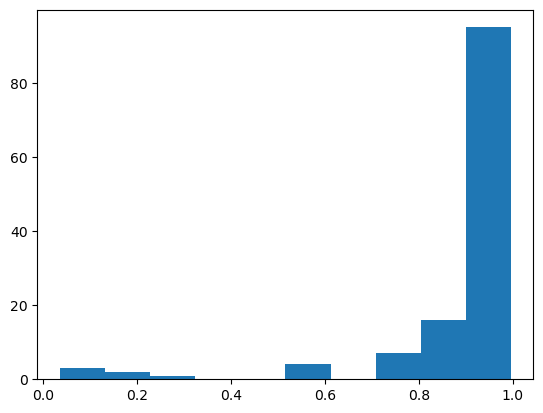

In [32]:
from matplotlib import pyplot as plt
plt.hist(torch.sigmoid(model.cpu().feature_selector.variational_parameter()).detach().numpy(), bins=10)
plt.show()

In [33]:
print((torch.sigmoid(model.feature_selector.variational_parameter()).detach().numpy() < 0.5).sum())
print((torch.sigmoid(model.feature_selector.variational_parameter()).detach().numpy() < 0.5))

6
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False]


In [53]:
from matplotlib import pyplot as plt

def plot_band_selection(features_selected:np.ndarray, samples:list, sample_labels=None, wavelength=None, n_features=-1):
    if sample_labels is not None:
        assert(len(samples) == len(sample_labels))
    else:
        sample_labels = [None] * len(samples)

    diff = np.diff(features_selected)
    features_ranges = np.split(features_selected, np.where(diff != 1)[0]+1)

    with plt.style.context('seaborn-colorblind'):
        fig = plt.figure()
        for idx, sample in enumerate(samples):
            plt.plot(sample, label=sample_labels[idx])
            plt.scatter(features_selected, sample[features_selected], alpha=.5)

        for r in features_ranges:
            plt.axvspan(r[0]-.25, r[-1]+.25, alpha=0.25)

        if wavelength is not None:
            ticks = np.linspace(0, len(wavelength)-1, 12, dtype=int)
            plt.xlabel('Wavelength (nm)', fontsize='x-large')
            plt.xticks(ticks, wavelength[ticks], rotation=45, fontsize='large')

        plt.ylabel('Reflectance', fontsize='x-large')
        plt.yticks(fontsize='large')
        
        if sample_labels[0] is not None:
            plt.legend(loc='upper right')
    
        if n_features != -1:
            sparse_rate = (n_features - len(features_selected)) / n_features 
            title = 'Sparsity: {:.2f}'.format(sparse_rate)
            plt.title(title, fontsize='xx-large')
 
        plt.margins(x=0.01)

    return fig

tensor(2) tensor(0) tensor(1)


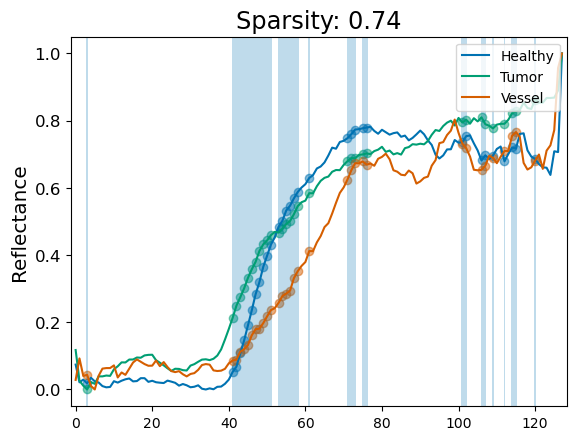

In [54]:
from scipy.io import loadmat

# mat = loadmat('/home/abian/Data/Dataset/IUMA/Experimento (Abian)/preProcessedWavelength.mat')
# wv = mat['preProcessedVnirWl']

X, y = dataset.X, dataset.y
print(y[1000], y[100], y[3500])

fig = plot_band_selection(torch.where(torch.sigmoid(model.feature_selector.variational_parameter()) < 0.9)[0], X[[1000, 100, 3500]], sample_labels=['Healthy', 'Tumor', 'Vessel'], n_features=128)


In [ ]:
np.unique(np.clip(config.WAVELENGTH, config.clip_wavelenght_range[0], config.clip_wavelenght_range[1]))

In [ ]:
a = VNIRimagesOp8C1()

a.run()

In [ ]:
import pandas as pd

X_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp8C2.csv'))
y_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp8C2_gt.csv'))

X_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp12C2.csv'))
y_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp12C2_gt.csv'))

X_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp15C1.csv'))
y_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp15C1_gt.csv'))

X_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp20C1.csv'))
y_df = pd.read_csv(os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/', 'VNIRimagesOp20C1_gt.csv'))

X = X_df.to_numpy()
y = y_df.to_numpy()

In [ ]:
import numpy as np
for i in np.unique(y):
    print(i, np.sum(y == i))

In [ ]:
os.path.join(config.BRAIN_HSI_DIR, 'preprocessed/data/no_outliers/VNIRimagesOp8C1.csv')

In [ ]:
hidden_size = [128, 254, 64, 32, 3]

for idx, (x, y) in enumerate(sliding_window_iter(hidden_size, 2)):
    print(x,y)
    # check if it is the iteration
    print(idx)
    if idx == ((len(hidden_size) + 1) // 2):
        print('Ultima')
    
    


In [ ]:
def _hidden_layer(in_features, out_features, output=False):
    if output:
        return nn.Linear(in_features, out_features)
    else:
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features, affine=False),
            nn.ReLU(inplace=True),
            nn.Dropout(.5),
        )

layers = []
for idx, (in_features, out_features) in enumerate(sliding_window_iter(hidden_size, 2)):
    last = (True if idx == ((len(hidden_size) + 1) // 2) else False)
    layers.append(_hidden_layer(in_features, out_features, last))

nn.Sequential(*layers)

In [ ]:
hidden_size = [128, 254, 64, 32, 3]
print((len(hidden_size )+1)//2)

hidden_size = [128, 254, 64, 3]
print((len(hidden_size)+1)//2)
